In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy

In [55]:
from bandits import MetaBanditEnv
from exact import solve
from blinkered_bandits import blinkered

def parse(row):
    if row[0] < 0:
        return None
    row = row.tolist()
    arms = range(len(row) // 2)
    return tuple((row[a*2], row[a*2 + 1]) for a in arms)

template= '../matlab_code/GeneralMDP/states{n_arm}{max_obs}.csv'

def make_df(n_arm):
    max_obs = 10
    cost = 0
    env = MetaBanditEnv(n_arm, max_obs, cost)
    states = pd.read_csv(template.format(n_arm=n_arm, max_obs=max_obs))
    states = states.apply(parse, axis=1).iloc[:-1]

    Q, V, pi, info = solve(env)
    
    def get_qs(s):
        if len(env.actions(s)) == 1:
            return [0] * n_arm + [Q(s, n_arm)]
        else:
            return [Q(s, a) for a in range(n_arm+1)]

    return pd.DataFrame(np.stack(states.apply(get_qs)))

def write_csvs():
    for n_arm in range(2, 6):
        df = make_df(n_arm)
        df.to_csv('results/bandit_q_{n_arm}_{max_obs}.csv'.format(n_arm=n_arm, max_obs=max_obs),
                  header=False, index=False)


In [148]:
%%time
env = MetaBanditEnv(3, 26, 0.01)
Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
print(V(env.init))
info

0.6420228649995051
CPU times: user 7.57 s, sys: 161 ms, total: 7.73 s
Wall time: 7.77 s


In [115]:
from contexttimer import Timer

In [146]:
np.logspace(0, 4, 5, base=2)

array([  1.,   2.,   4.,   8.,  16.])

In [149]:
%%time

def data():
    for n_arm in range(2, 5):
        for max_obs in np.logspace(1, 5, 5, base=2):
            for cost in [0.0001, 0.001, .01]:
                env = MetaBanditEnv(n_arm, max_obs, cost)
                Q, V, pi, info = solve(env, hash_state=lambda s: tuple(sorted(s)))
                with Timer() as timer:
                    v = V(env.init)
                    t = timer.elapsed
                yield dict(
                    n_arm=n_arm,
                    max_obs=max_obs,
                    cost=cost,
                    time=t,
                    v=v,
                )
                
df = pd.DataFrame(data())

CPU times: user 14min 19s, sys: 19.6 s, total: 14min 39s
Wall time: 14min 56s


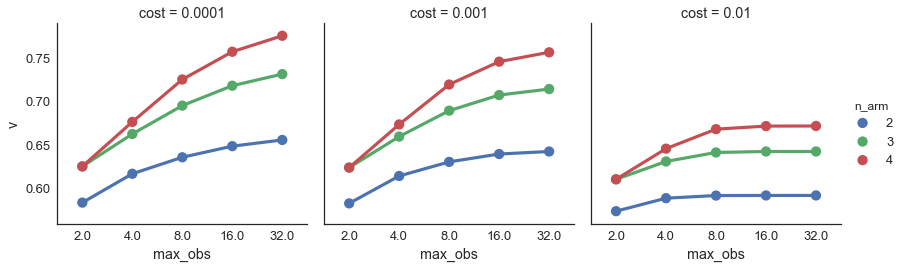

In [153]:
sns.factorplot('max_obs', 'v', hue='n_arm', data=df, col='cost')

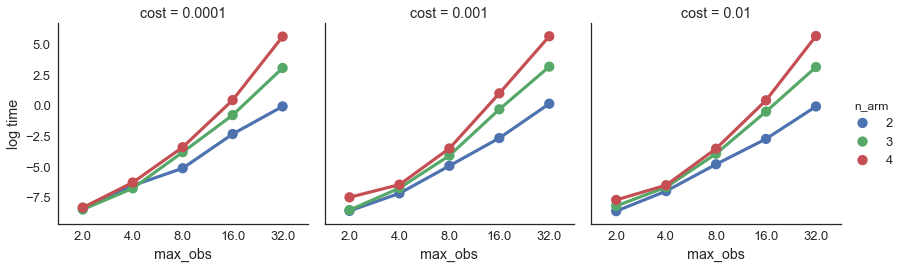

In [183]:
df['log time'] = np.log(df.time)
sns.factorplot('max_obs', 'log time', hue='n_arm', data=df, col='cost')

# Foobar

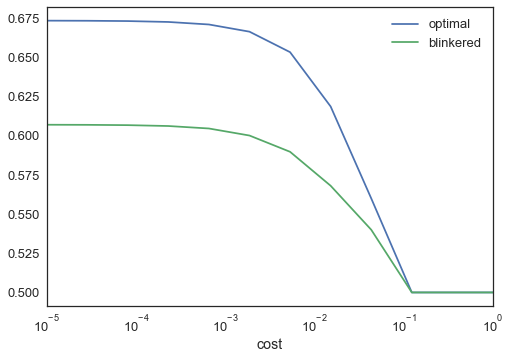

In [96]:
def data():
    n_arm = 3
    max_obs = 5
    for cost in np.logspace(-5, 0, 12):
        env = MetaBanditEnv(n_arm, max_obs, cost)
        yield {'optimal': solve(env)[1](env.init),
               'blinkered': blinkered(env)[1](env.init),
               'cost': cost,
               'n_arm': n_arm,
               'max_obs': max_obs}
        
df = pd.DataFrame(data())
df.set_index('cost')[['optimal', 'blinkered']].plot()
ax = plt.gca()
ax.set_xscale('log')

In [93]:
pd.DataFrame.plot.line?

In [84]:
df.cost

0    1.000000e-08
1    1.000000e-06
2    1.000000e-04
3    1.000000e-02
4    1.000000e+00
Name: cost, dtype: float64

In [80]:
df

,blinkered,cost,max_obs,n_arm,optimal
0,0.603443,0.001,5,3,0.669833
1,0.500000,0.100,5,3,0.500000


In [75]:
from blinkered_bandits import blinkered
env = MetaBanditEnv(3, 10, .01)
Q, V, pi, info = solve(env)

Q1, V1, pi1, info1 = blinkered(env)
V1(env.init), V(env.init)

(0.5767619047619048, 0.6416982804232804)